In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-sign-dataset-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1794080%2F2952603%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T121829Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1e77386e0f74f3c2a572d9fc81c015f6bc114a13cb5743ded039bfd7b5c06a67df932fb70fae758fdb749ff04144d7230f63ff7bf88ff0d9fa5352fdd8e9779320fc328265f440ee6e53444e653bc53d58a49dd25d1f20f76b7a0ce2673ace6ce6c0cb889822045d55a0a03d425ae80bf61c6046e89118009391f82cb15c5ddcef0fef4e874a92c5f242679ee3ed00c04c5e4373194a5dd419ab86a3bc36adc3931dd2dbecaed8e32bfe70f0acab1e44a9769b0581d4fecdd14ee521597a8859cfaab54940eed5b48c9647c4216067d850789c0d532409ca1cd3aa0a2aabddf8629300dcb732459523e83dde495f5a8721f5ab6fa849a3b5f22b44e2f4dcf4c3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
datadir='/kaggle/input/traffic-sign-dataset-classification/traffic_Data'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
transforms = [T.Resize((256,256)),
              T.Grayscale(),
              T.ToTensor()]
transform = T.Compose(transforms)

In [ ]:
dataset=datasets.ImageFolder(datadir,transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

trainset, testset = random_split(dataset=dataset,
                                 lengths=[train_size, test_size])

In [ ]:
batch_size=64 # размер пакета
train_loader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True )

dataloaders = {"train": train_loader,"validation": test_loader}

torch.Size([64, 1, 256, 256])
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])


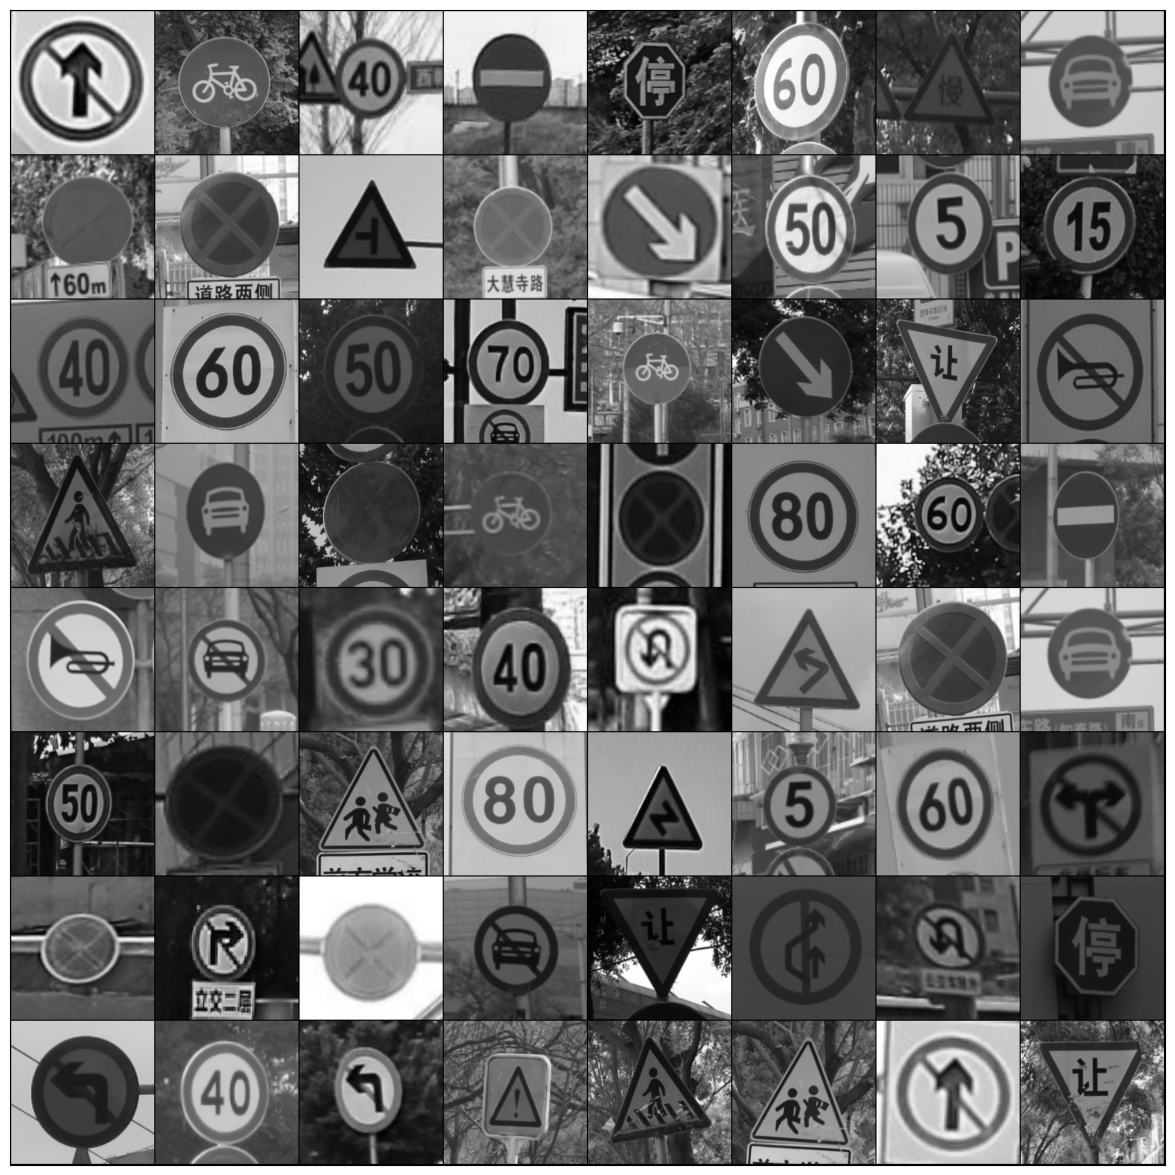

In [ ]:
for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        print(labels[:64])
        break

In [ ]:
import torch.nn as nn

class Traffic_CNN(nn.Module):
  def __init__(self):
    super(Traffic_CNN, self).__init__()

    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
        )

    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )

    self.layer_3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.AvgPool2d(64)
    )

    self.linear_layer_4 = nn.Linear(128, 58)

  def forward(self,x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = x.view(x.size(0),-1)
    x = self.linear_layer_4(x)
    return x

In [ ]:
model=Traffic_CNN()
model.to(device)

Traffic_CNN(
  (layer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Conv2d(6

In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model,input_size=(64, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Traffic_CNN                              [64, 58]                  --
├─Sequential: 1-1                        [64, 32, 128, 128]        --
│    └─Conv2d: 2-1                       [64, 32, 256, 256]        320
│    └─ReLU: 2-2                         [64, 32, 256, 256]        --
│    └─BatchNorm2d: 2-3                  [64, 32, 256, 256]        64
│    └─Conv2d: 2-4                       [64, 32, 256, 256]        9,248
│    └─ReLU: 2-5                         [64, 32, 256, 256]        --
│    └─BatchNorm2d: 2-6                  [64, 32, 256, 256]        64
│    └─MaxPool2d: 2-7                    [64, 32, 128, 128]        --
├─Sequential: 1-2                        [64, 64, 64, 64]          --
│    └─Conv2d: 2-8                       [64, 64, 128, 128]        18,496
│    └─ReLU: 2-9                         [64, 64, 128, 128]        --
│    └─BatchNorm2d: 2-10                 [64, 64, 128, 128]        128
│    └

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy, RunningAverage, ConfusionMatrix
from ignite.handlers import EarlyStopping, ModelCheckpoint, Checkpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler

Создаем движок для обучения и задаем метрики

In [ ]:
trainer = create_supervised_trainer(model=model,
                                    optimizer=optimizer,
                                    loss_fn=criterion,
                                    device=device)
metrics = {'loss': Loss(criterion),
           'accuracy': Accuracy(),
           'cm': ConfusionMatrix(num_classes=58)}

Задаем вычисление метрик

In [ ]:
train_evaluator = create_supervised_evaluator(model, device=device, metrics=metrics)
test_evaluator = create_supervised_evaluator(model, device=device, metrics=metrics)

training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print(f"Результат обучения - Эпоха: {trainer.state.epoch}  Сред. точность: {accuracy :.3f} Сред. ошибка: {loss :.3f}")

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print(f"Результат валидации - Эпоха: {trainer.state.epoch}  Сред. точность: {accuracy :.3f} Сред. ошибка: {loss :.3f}")

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
trainer.run(train_loader, max_epochs=10)

  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 79.254 Сред. ошибка: 1.251
Результат валидации - Эпоха: 1  Сред. точность: 78.994 Сред. ошибка: 1.313


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 83.553 Сред. ошибка: 0.973
Результат валидации - Эпоха: 2  Сред. точность: 83.049 Сред. ошибка: 0.966


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 73.616 Сред. ошибка: 1.007
Результат валидации - Эпоха: 3  Сред. точность: 75.912 Сред. ошибка: 0.918


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 81.099 Сред. ошибка: 0.472
Результат валидации - Эпоха: 4  Сред. точность: 78.913 Сред. ошибка: 0.501


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 86.494 Сред. ошибка: 0.331
Результат валидации - Эпоха: 5  Сред. точность: 85.888 Сред. ошибка: 0.335


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 86.412 Сред. ошибка: 0.329
Результат валидации - Эпоха: 6  Сред. точность: 86.537 Сред. ошибка: 0.334


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 86.068 Сред. ошибка: 0.336
Результат валидации - Эпоха: 7  Сред. точность: 85.807 Сред. ошибка: 0.348


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 82.803 Сред. ошибка: 0.371
Результат валидации - Эпоха: 8  Сред. точность: 83.617 Сред. ошибка: 0.352


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 88.136 Сред. ошибка: 0.290
Результат валидации - Эпоха: 9  Сред. точность: 88.240 Сред. ошибка: 0.301


  1%|1         | 1/78 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 86.757 Сред. ошибка: 0.316
Результат валидации - Эпоха: 10  Сред. точность: 84.834 Сред. ошибка: 0.330


State:
	iteration: 780
	epoch: 10
	epoch_length: 78
	max_epochs: 10
	output: 0.11169569939374924
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

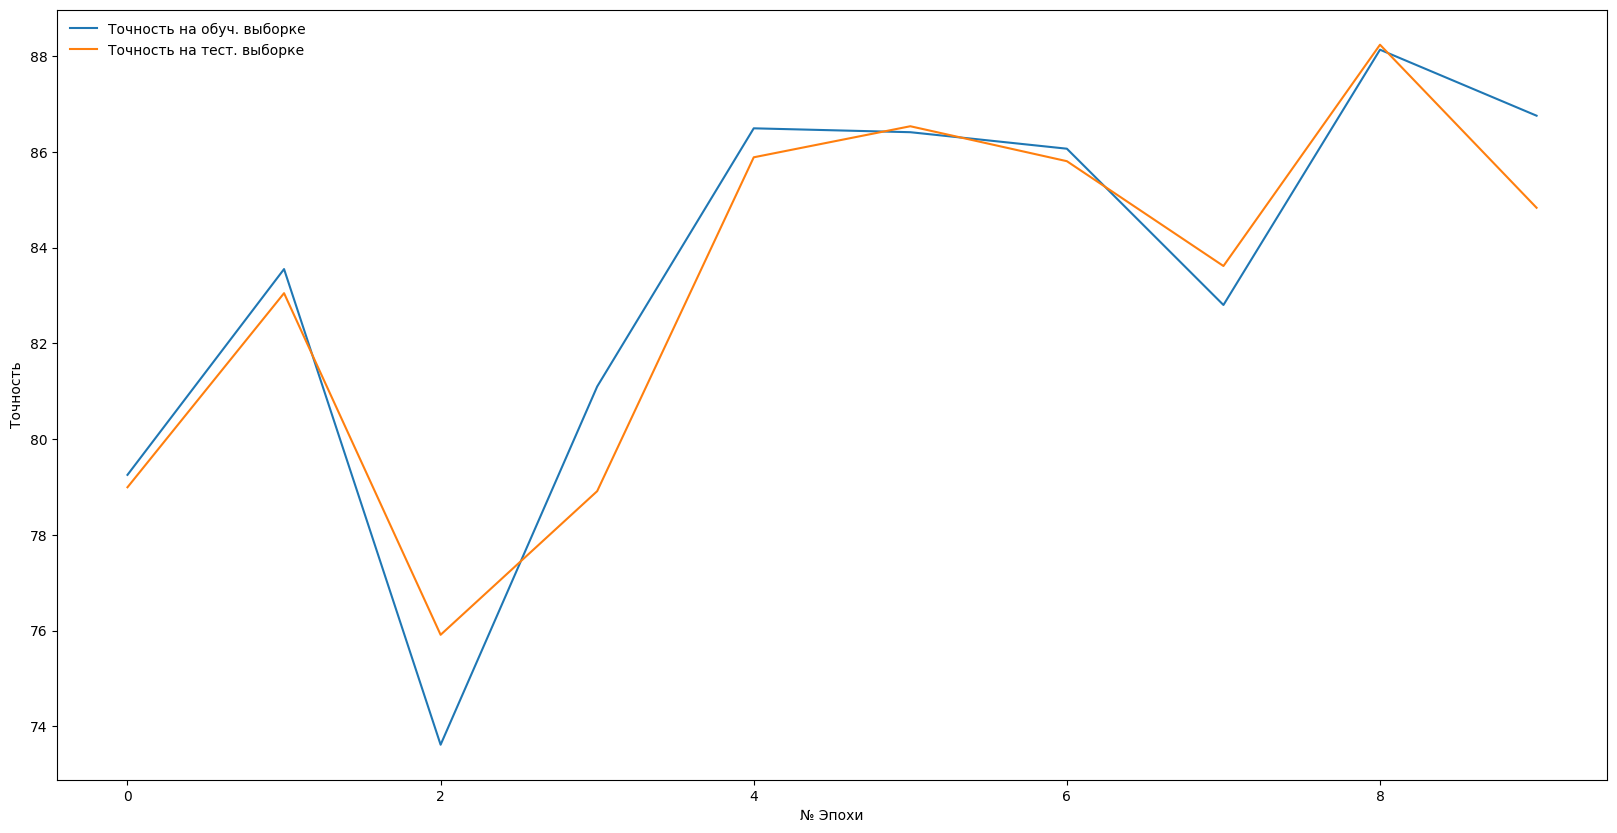

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

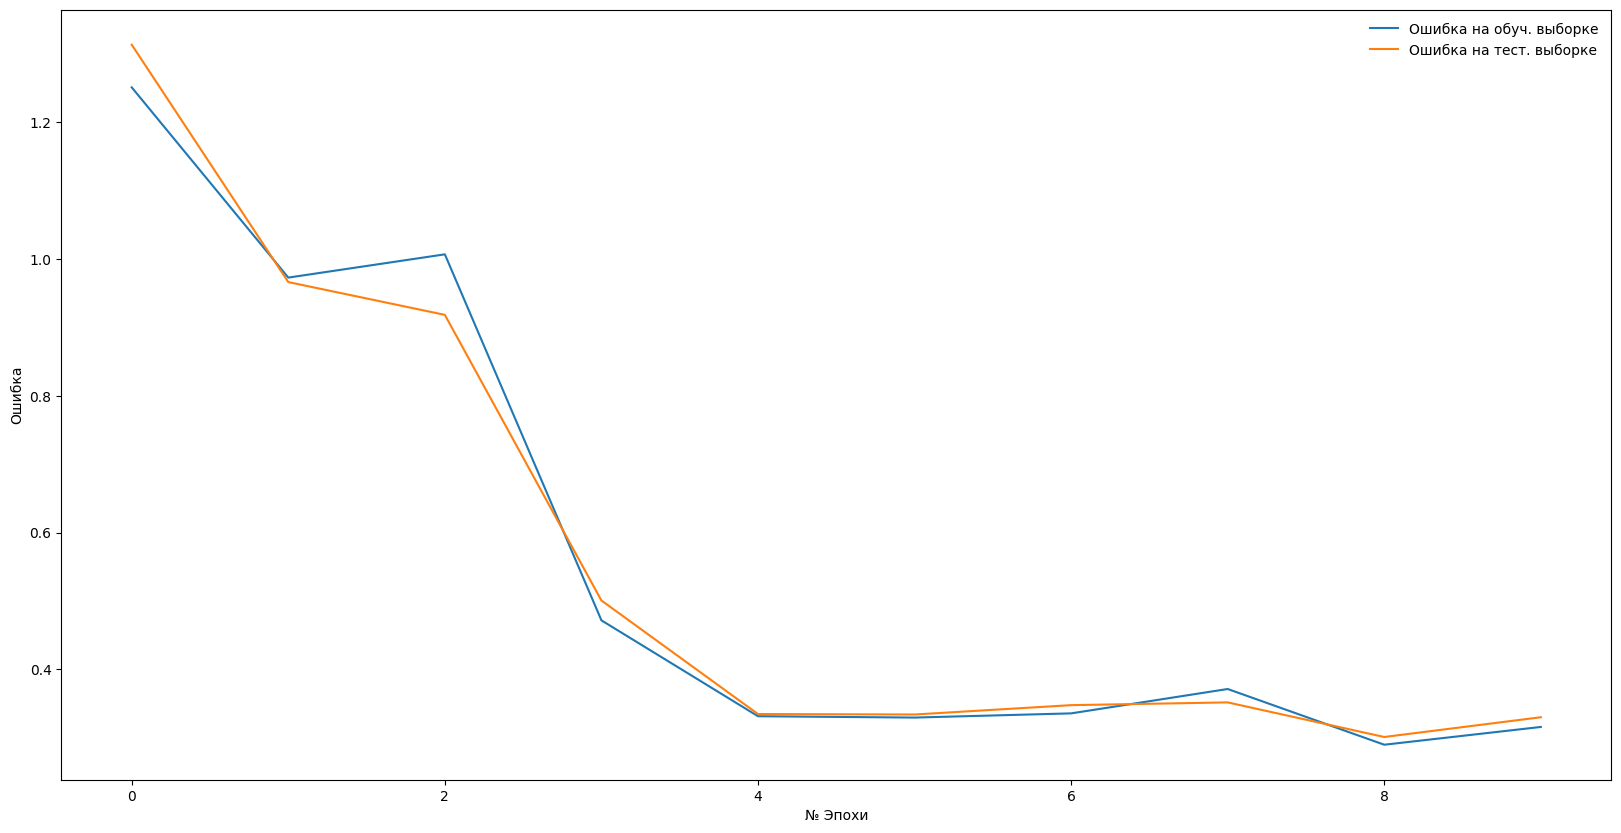

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Ошибка')
plt.legend(frameon=False)
plt.show()